# LSTM model

## Model training

The architecture of the LSTM model is shown below:

*   **Baseline Model:** Recurrent Neural Network (RNN) utilizing Long Short-Term Memory units
*   **Input Layer:** 128 neurons
*   **Hidden Layer 1 (Dense):** 64 neurons
*   **Hidden Layer 2 (Dense):** 64 neurons
*   **Optimizer**: Adam
*   **Learning Rate**: 0.001


### LSTM model 1: 10 min input -> 10 min output

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import os
from google.colab import drive

# Ensure Google Drive is mounted to access files (this is a safeguard)
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# Re-define base_dir and load dataframes to ensure they are available
# as the kernel state might have reset or global variables might not persist across all executions.
base_dir = "/content/drive/MyDrive/Deep Learning/Project 2/Spain/"
generation_file = os.path.join(base_dir, "spain_energy_generation_merged_with interpolation with noise.csv")
frequency_file = os.path.join(base_dir, "spain_electrical_grid_frequency.csv")

df_gen = pd.read_csv(generation_file)
df_freq = pd.read_csv(frequency_file)

df_gen['datetime'] = pd.to_datetime(df_gen['datetime'], utc=True)
df_gen.set_index('datetime', inplace=True)

df_freq['datetime'] = pd.to_datetime(df_freq['datetime'], utc=True)
df_freq.set_index('datetime', inplace=True)

df_gen_resampled = df_gen.resample('10min').mean()
df_freq_resampled = df_freq.resample('10min').mean()

df_merged = pd.merge(df_gen_resampled, df_freq_resampled, left_index=True, right_index=True, how='inner')

# 1. Define Features and Target (using _x suffix as defined in previous steps)
feature_cols = ['Solar PV', 'Solar Thermal', 'Wind', 'Nuclear', 'Hydro', 'Coal', 'Total Generation_x', 'Demand_x']
target_col = 'Frequency'

X_raw = df_merged[feature_cols].values
y_raw = df_merged[[target_col]].values

# 2. Scale Data
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

X_scaled = scaler_X.fit_transform(X_raw)
y_scaled = scaler_y.fit_transform(y_raw)

# 3. Create Sliding Window Sequences
def create_sequences(data_X, data_y, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(data_X) - seq_length):
        X_seq.append(data_X[i:i+seq_length])
        y_seq.append(data_y[i+seq_length])
    return np.array(X_seq), np.array(y_seq)

SEQ_LENGTH = 12  # 2 hours of 10-min data
X_seq, y_seq = create_sequences(X_scaled, y_scaled, SEQ_LENGTH)

# 4. Train/Test Split (80/20 Chronological)
split_idx = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]

# 1. Build LSTM model
model = Sequential([
    LSTM(50, input_shape=(SEQ_LENGTH, len(feature_cols))),
    Dense(1)
])

# 2. Compile model
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

# 3. Train the LSTM model
print("\n⏳ Training LSTM model...")
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=64,
    validation_data=(X_test, y_test),
    verbose=1
)

Mounted at /content/drive


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        11,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,851 (46.29 KB)

 Trainable params: 11,851 (46.29 KB)

 Non-trainable params: 0 (0.00 B)


⏳ Training LSTM model...
Epoch 1/20
1764/1764 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - loss: 0.0231 - val_loss: 0.0138
Epoch 2/20
1764/1764 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - loss: 0.0132 - val_loss: 0.0125
Epoch 3/20
1764/1764 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - loss: 0.0093 - val_loss: 0.0113
Epoch 4/20
1764/1764 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - loss: 0.0071 - val_loss: 0.0125
Epoch 5/20
1764/1764 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - loss: 0.0062 - val_loss: 0.0150
Epoch 6/20
1764/1764 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - loss: 0.0053 - val_loss: 0.0184
Epoch 7/20
1764/1764 ━━━━━━━━━━━━━━━━━━━━ 22s 12ms/step - loss: 0.0048 - val_loss: 0.0213
Epoch 8/20
1764/1764 ━━━━━━━━━━━━━━━━━━━━ 25s 14ms/step - loss: 0.0044 - val_loss: 0.0247
Epoch 9/20
1764/1764 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - loss: 0.0039 - val_loss: 0.0252
Epoch 10/20
1764/1764 ━━━━━━━━━━━━━━━━━━━━ 23s 12ms/step - loss: 0.0035 - val_loss: 0.0270
Epoch 11/20
1764/1764 ━━━━━━━━━━━━━━━━━━━━ 23s 13ms/step - loss: 0.0032 -

## Model evaluation

Making predictions...
882/882 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step

Evaluation Metrics:
Mean Absolute Error (MAE): 0.07871
Root Mean Squared Error (RMSE): 0.24623
R^2 Score: 0.17770


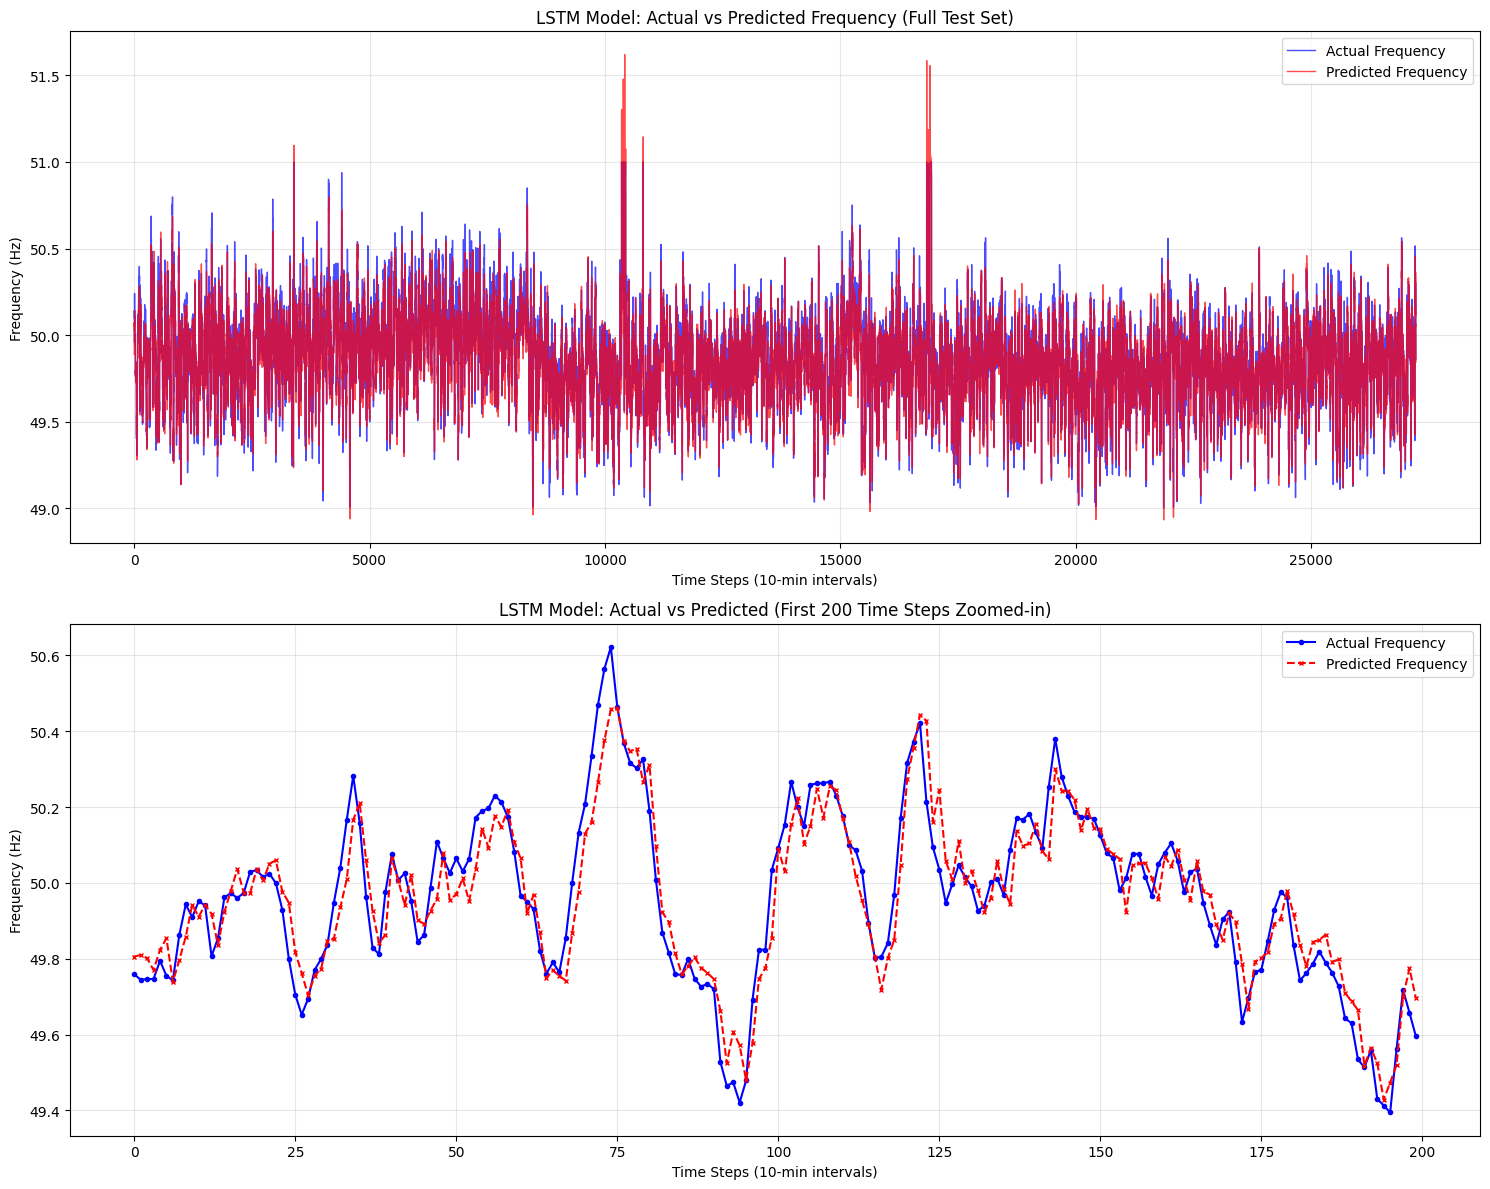

In [3]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 1. Make Predictions
print("Making predictions...")
y_pred_scaled = model.predict(X_test)

# 2. Inverse Transform to original scale
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_orig = scaler_y.inverse_transform(y_test)

# 3. Calculate Metrics
mae = mean_absolute_error(y_test_orig, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred))
r2 = r2_score(y_test_orig, y_pred)

print(f"\nEvaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.5f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.5f}")
print(f"R^2 Score: {r2:.5f}")

# 4. Plotting
plt.figure(figsize=(15, 12))

# Plot 1: Full Test Set
plt.subplot(2, 1, 1)
plt.plot(y_test_orig[1000:], label='Actual Frequency', color='blue', alpha=0.7, linewidth=1)
plt.plot(y_pred[1000:], label='Predicted Frequency', color='red', alpha=0.7, linewidth=1)
plt.title('LSTM Model: Actual vs Predicted Frequency (Full Test Set)')
plt.xlabel('Time Steps (10-min intervals)')
plt.ylabel('Frequency (Hz)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Zoomed In (e.g., first 200 points, approx 33 hours)
zoom_steps = 200
plt.subplot(2, 1, 2)
plt.plot(y_test_orig[:zoom_steps], label='Actual Frequency', color='blue', marker='o', markersize=3, linestyle='-')
plt.plot(y_pred[:zoom_steps], label='Predicted Frequency', color='red', marker='x', markersize=3, linestyle='--')
plt.title(f'LSTM Model: Actual vs Predicted (First {zoom_steps} Time Steps Zoomed-in)')
plt.xlabel('Time Steps (10-min intervals)')
plt.ylabel('Frequency (Hz)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()